In [1]:
import matplotlib.pyplot as plt
import numpy as np

def symbolic_sequence_f(orbit, num_partitions):

    def split_partitions(num_partitions):
        symbols = list(range(1, num_partitions + 1))
        partitions = []

        partition_points = np.linspace(0, 1, num_partitions + 1)

        for i in range(num_partitions):
            start = partition_points[i]
            end = partition_points[i + 1]
            symbol = partition_points[i]
            partitions.append((start, end, symbol))
        return partitions


    sequence = []
    partitions = split_partitions(num_partitions)

    for x in orbit:
        
        # Determinar en qué partición cae x y agregar el símbolo correspondiente
        for (start, end, symbol) in partitions:
            if start <= x < end:
                sequence.append(symbol)
                break

    return sequence

In [2]:
def J_bivariante(X,Y,tau,fases):
    def distancia(p1, p2):
        return np.linalg.norm(np.array(p2)-np.array(p1))
    ff1 = np.angle(np.fft.rfft(X))[:fases]
    ff2 = np.angle(np.fft.rfft(Y))[:fases]
    vectores = []
    for i in range(len(ff1)-1):
        p1 = [ff1[i], ff2[i]]
        p2 = [ff1[i+1], ff2[i+1]]
        cuadrante = [[p2[0]-p1[0], p2[1]-p1[1]], [p2[0]-p1[0], p2[1]+2*np.pi-p1[1]],
            [p2[0]+2*np.pi-p1[0],p2[1]+2*np.pi-p1[1]],[p2[0]+2*np.pi-p1[0],p2[1]-p1[1]],
            [p2[0]+2*np.pi-p1[0],p2[1]-2*np.pi-p1[1]],[p2[0]-p1[0],p2[1]-2*np.pi-p1[1]],
            [p2[0]-2*np.pi-p1[0],p2[1]-2*np.pi-p1[1]],[p2[0]-2*np.pi-p1[0],p2[1]-p1[1]],
            [p2[0]-2*np.pi-p1[0],p2[1]+2*np.pi-p1[1]]]
        distancia1 = [distancia(p1,c) for c in cuadrante]
        p2=cuadrante[np.argmin(distancia1)]
        vectores.append([p2[0]-p1[0],p2[1]-p1[1]])
    angulos=[]
    for i in range(len(vectores)-1):
        v1=vectores[i]
        v2=vectores[i+1]
        v1_norm=v1/np.linalg.norm(v1)
        v2_norm=v2/np.linalg.norm(v2)
        angulo=np.arccos(np.clip(np.dot(v1_norm,v2_norm),-1.0,1.0))
        cruz=v1[0]*v2[1]-v1[1]*v2[0]
        if cruz>0:
            angulo=np.pi-angulo
        if cruz==0 and angulo==0:
            angulo=angulo
        if cruz==0 and angulo<0:
            angulo=np.pi
        if cruz<0:
            angulo=angulo+np.pi
        angulos.append(angulo)
    e=[]
    for k in range(len(angulos)):
        e.append(np.exp(angulos[k]*1j))
    e1=np.sum(e)/len(angulos)
    J=1.-np.abs(e1.real)
    return J

In [3]:
def J_univariante(X,tau,fases):
    def distancia(p1, p2):
        return np.linalg.norm(np.array(p2)-np.array(p1))
    x1 = X[tau:]
    y1 = X[:-tau]
    ff1 = np.angle(np.fft.rfft(x1))[:fases]
    ff2 = np.angle(np.fft.rfft(y1))[:fases]
    # ff1 = transition_point(ff1, 6)
    # ff2 = transition_point(ff2, 50)
    
    vectores = []
    for i in range(len(ff1)-1):
        p1 = [ff1[i], ff2[i]]
        p2 = [ff1[i+1], ff2[i+1]]
        cuadrante = [[p2[0]-p1[0], p2[1]-p1[1]], [p2[0]-p1[0], p2[1]+2*np.pi-p1[1]],
            [p2[0]+2*np.pi-p1[0],p2[1]+2*np.pi-p1[1]],[p2[0]+2*np.pi-p1[0],p2[1]-p1[1]],
            [p2[0]+2*np.pi-p1[0],p2[1]-2*np.pi-p1[1]],[p2[0]-p1[0],p2[1]-2*np.pi-p1[1]],
            [p2[0]-2*np.pi-p1[0],p2[1]-2*np.pi-p1[1]],[p2[0]-2*np.pi-p1[0],p2[1]-p1[1]],
            [p2[0]-2*np.pi-p1[0],p2[1]+2*np.pi-p1[1]]]
        distancia1 = [distancia(p1,c) for c in cuadrante]
        p2 = cuadrante[np.argmin(distancia1)]
        vectores.append([p2[0]-p1[0],p2[1]-p1[1]])
    angulos = []
    for i in range(len(vectores)-1):
        v1=vectores[i]
        v2=vectores[i+1]
        v1_norm=v1/np.linalg.norm(v1)
        v2_norm=v2/np.linalg.norm(v2)
        angulo=np.arccos(np.clip(np.dot(v1_norm,v2_norm),-1.0,1.0))
        cruz=v1[0]*v2[1]-v1[1]*v2[0]
        if cruz>0:
            angulo=np.pi-angulo
        if cruz==0 and angulo==0:
            angulo=angulo
        if cruz==0 and angulo<0:
            angulo=np.pi
        if cruz<0:
            angulo=angulo+np.pi
        angulos.append(angulo)
    e=[]
    for k in range(len(angulos)):
        e.append(np.exp(angulos[k]*1j))
    e1=np.sum(e)/len(angulos)
    J=1.-np.abs(e1.real)
    return J

In [4]:
import numpy as np

def lyapunov_exponent_from_orbit(orbit, r):
    lyapunov_sum = 0

    for x in orbit:
        # Derivada de la función logística
        derivative = abs(r * (1 - 2 * x))
        if derivative == 0:
            lyapunov_sum += 0
        else:
            lyapunov_sum += np.log(derivative)

    # Calcular el exponente de Lyapunov
    lyapunov_exponent = lyapunov_sum / len(orbit)
    return lyapunov_exponent


In [207]:
"""interpolacion despues de dinamica simbolica"""

import numpy as np
import matplotlib.pyplot as plt
import import_ipynb
from scipy.interpolate import PchipInterpolator



def logistic_map(r, x):
    return r * x * (1 - x)

def plot_orbit_diagram(num_partitions,discreto,interpolacion, size,graficar, r_min = 3.0, r_max = 4.0, num_points_per_r=300,
 num_iterations_discard=1000, num_iterations_display=2000):
    if discreto == "no" and interpolacion == "si": 
        print("Haz seleccionado interpolación a los datos continuos, eso no tiene caso")
        return 1,2

    if interpolacion == "si":
        print("Interpolación")

    r_values = []
    orbit_values = []
    
    for r in np.linspace(r_min, r_max, num_points_per_r):
        
        x = 0.6
        for _ in range(num_iterations_discard): # Converger
            x = logistic_map(r, x)

        
        for _ in range(num_iterations_display):
            x = logistic_map(r, x)
            r_values.append(r)
            orbit_values.append(x)
    #A partir de aqui, orbita continua de logistica completada
    if discreto == "si":
        print('Dinámica simbólica')
        orbit_values = symbolic_sequence_f(orbit_values, num_partitions)


        

    a = 0
    J_values=[]
    J_index=[]
    lyapunov_values = []
    
    r_values_interp = []
    orbit_values_interp = np.array([])

    for i in range(0, len(r_values) - 1):
        if r_values[i] != r_values[i+1]:
            r_single_orbit = orbit_values[a:i+1]
            a = i+1
            
            if interpolacion == 'si':
                x = np.arange(len(r_single_orbit))
                x_new = np.linspace(0, len(r_single_orbit) - 1, size)
                x_new = np.unique(np.concatenate((x, x_new)))  
                
                data_interp = np.interp(x_new, x, r_single_orbit)
                # interpolator = PchipInterpolator(x, r_single_orbit)
                # data_interp = interpolator(x_new)
                r_values_interp = r_values_interp + [r_values[i]]*len(data_interp)
                orbit_values_interp = np.concatenate((orbit_values_interp, data_interp))

                r_single_orbit = data_interp


            lyapunov = lyapunov_exponent_from_orbit(r_single_orbit, r_values[i])
            lyapunov_values.append(lyapunov)

            J = J_univariante(r_single_orbit, 1, int(len(r_single_orbit)))
            if any(np.isnan(valor) for valor in r_single_orbit):
                print(r_values[i])
            J_values.append(J)
            J_index.append(r_values[i])
    
    #ultimo valor de r
    lyapunov = lyapunov_exponent_from_orbit(orbit_values[a:], r_values[len(r_values) - 1])  
    lyapunov_values.append(lyapunov)
    J = J_univariante(orbit_values[a:], 1, int(len(r_single_orbit)))
    J_values.append(J)
    J_index.append(r_values[len(r_values) - 1])

    #A partir de aqui, lyapunob y J fueron calculados

    with open('logistic_map/j_logistic_continuo.txt', 'r') as f:
        J_continuo = [float(line.strip()) for line in f]
    
    if graficar == True:
        fig, ax1 = plt.subplots(figsize=(10,6))
        
        if discreto == "no":
            color = "red"
        elif discreto == "si":
            color = "gray"
        ax1.plot(J_index, J_values, color , label='J', alpha = 1)

        if discreto == "si":
            ax1.plot(J_index, J_continuo, 'red', alpha = 0.3)
            if interpolacion == "si":
                ax1.plot(r_values_interp, orbit_values_interp, ',', label='Orbita', alpha=1)
            else: 
                ax1.plot(r_values, orbit_values, ',', label='Orbita', alpha=1)
        if discreto == "no":
            ax1.plot(r_values, orbit_values, ',', label='Orbita', alpha=1)
        ax1.set_xlabel('r')
        ax1.set_ylabel('J', color='r', rotation = 360)
        ax1.tick_params(axis='y', labelcolor='r')

        
        ax2 = ax1.twinx()
        if discreto == "si":

            ax2.axhline(y=0, color='black', linestyle='--', alpha =0.55)
            ax2.plot(J_index, lyapunov_values, 'black', label = 'λ')

        if discreto == "no":
            ax2.axhline(y=0, color='black', linestyle='--', alpha =0.55)
            ax2.plot(J_index, lyapunov_values, 'black', label = 'λ')
        ax2.set_ylabel('λ', color='black', rotation = 360)
        ax2.tick_params(axis='y', labelcolor='black')


        
        fig.tight_layout()  
        plt.title(f'Logistic Map (Discret ={discreto}, interp= {interpolacion})')

        plt.show()

    
    if interpolacion == 'no':
        return J_index, J_values, r_values, orbit_values, lyapunov_values
    else:
        return J_index, J_values, r_values_interp, orbit_values_interp, lyapunov_values 




# J_index, J_values, r_values, orbit_values, lyapunov_values = plot_orbit_diagram(2500,"si", "no", 2500,True)

72
[10.         24.08163265 38.16326531 40.         31.83673469 22.44897959
 20.         23.46938776 28.16326531 30.         24.28571429 14.89795918
 10.         16.73469388 30.81632653 40.         36.73469388 27.34693878
 20.         21.02040816 25.71428571 30.         29.18367347 19.79591837
 10.40816327 10.         23.46938776 37.55102041 40.         32.24489796
 22.85714286 20.         23.26530612 27.95918367 30.         24.69387755
 15.30612245 10.         16.12244898 30.20408163 40.         37.14285714
 27.75510204 20.         20.81632653 25.51020408 30.         29.59183673
 20.20408163 10.81632653 10.         22.85714286 36.93877551 40.
 32.65306122 23.26530612 20.         23.06122449 27.75510204 30.
 25.10204082 15.71428571 10.         15.51020408 29.59183673 40.
 37.55102041 28.16326531 20.         20.6122449  25.30612245 30.        ]


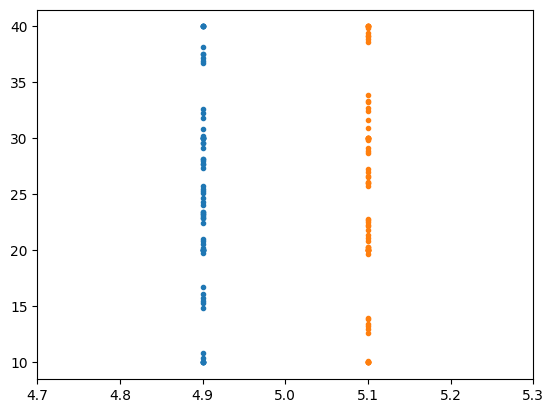

In [180]:
"""Entender interpolacion"""
import numpy as np
from scipy.interpolate import PchipInterpolator

# Generar 2000 datos aleatorios en el rango de 1 a 130
lista_aleatoria = np.random.randint(1, 101, size=20)

# Ordenar la lista de menor a mayor
lista_ordenada = np.sort(lista_aleatoria)

# Convertir a lista de Python (opcional)
y = lista_ordenada.tolist()
y = [10, 40, 20, 30]*6

x = np.arange(len(y))
x_new = np.linspace(0, len(y) - 1, 50)
x_new = np.unique(np.concatenate((x, x_new)))  
data_interp = np.interp(x_new, x, y)
interpolator = PchipInterpolator(x, y)
data_interp2 = interpolator(x_new)
print(len(data_interp))

plt.plot([4.9]*len(data_interp), data_interp, '.')
plt.xlim(4.7,5.3)
plt.plot([5.1]*len(data_interp2), data_interp2, '.')
print(data_interp)
# plt.plot([5]*len(y), y, '.',color = 'orange', alpha = 0.6)
plt.show()

In [200]:
from scipy.stats import spearmanr
df = pd.read_csv('logistic_map/df_30.csv')
# Supongamos que tienes un DataFrame llamado df
# df = pd.DataFrame({
#     'columna1': [1, 2, 3, 4, 5],
#     'columna2': [5, 6, 7, 8, 7]
# })

# Calcula la correlación de Spearman entre dos columnas
correlacion, p_valor = spearmanr(df['J'], df['J_interp'])
print(df['J_interp'])
correlacion

0      0.418790
1      0.418790
2      0.418790
3      0.418790
4      0.418790
         ...   
295    0.992754
296    0.990953
297    0.976142
298    0.954684
299    0.987936
Name: J_interp, Length: 300, dtype: float64


0.8698303027736136

Dinámica simbólica
Interpolación
Dinámica simbólica


C:\Users\PC BULLOCK\AppData\Local\Temp\ipykernel_19516\4227219246.py:28: RuntimeWarning: invalid value encountered in divide
  v2_norm=v2/np.linalg.norm(v2)
C:\Users\PC BULLOCK\AppData\Local\Temp\ipykernel_19516\4227219246.py:27: RuntimeWarning: invalid value encountered in divide
  v1_norm=v1/np.linalg.norm(v1)


Dinámica simbólica
Interpolación
Dinámica simbólica
Dinámica simbólica
Interpolación
Dinámica simbólica
Dinámica simbólica
Interpolación
Dinámica simbólica
Dinámica simbólica
Interpolación
Dinámica simbólica
Dinámica simbólica
Interpolación
Dinámica simbólica
Dinámica simbólica
Interpolación
Dinámica simbólica
Dinámica simbólica
Interpolación
Dinámica simbólica


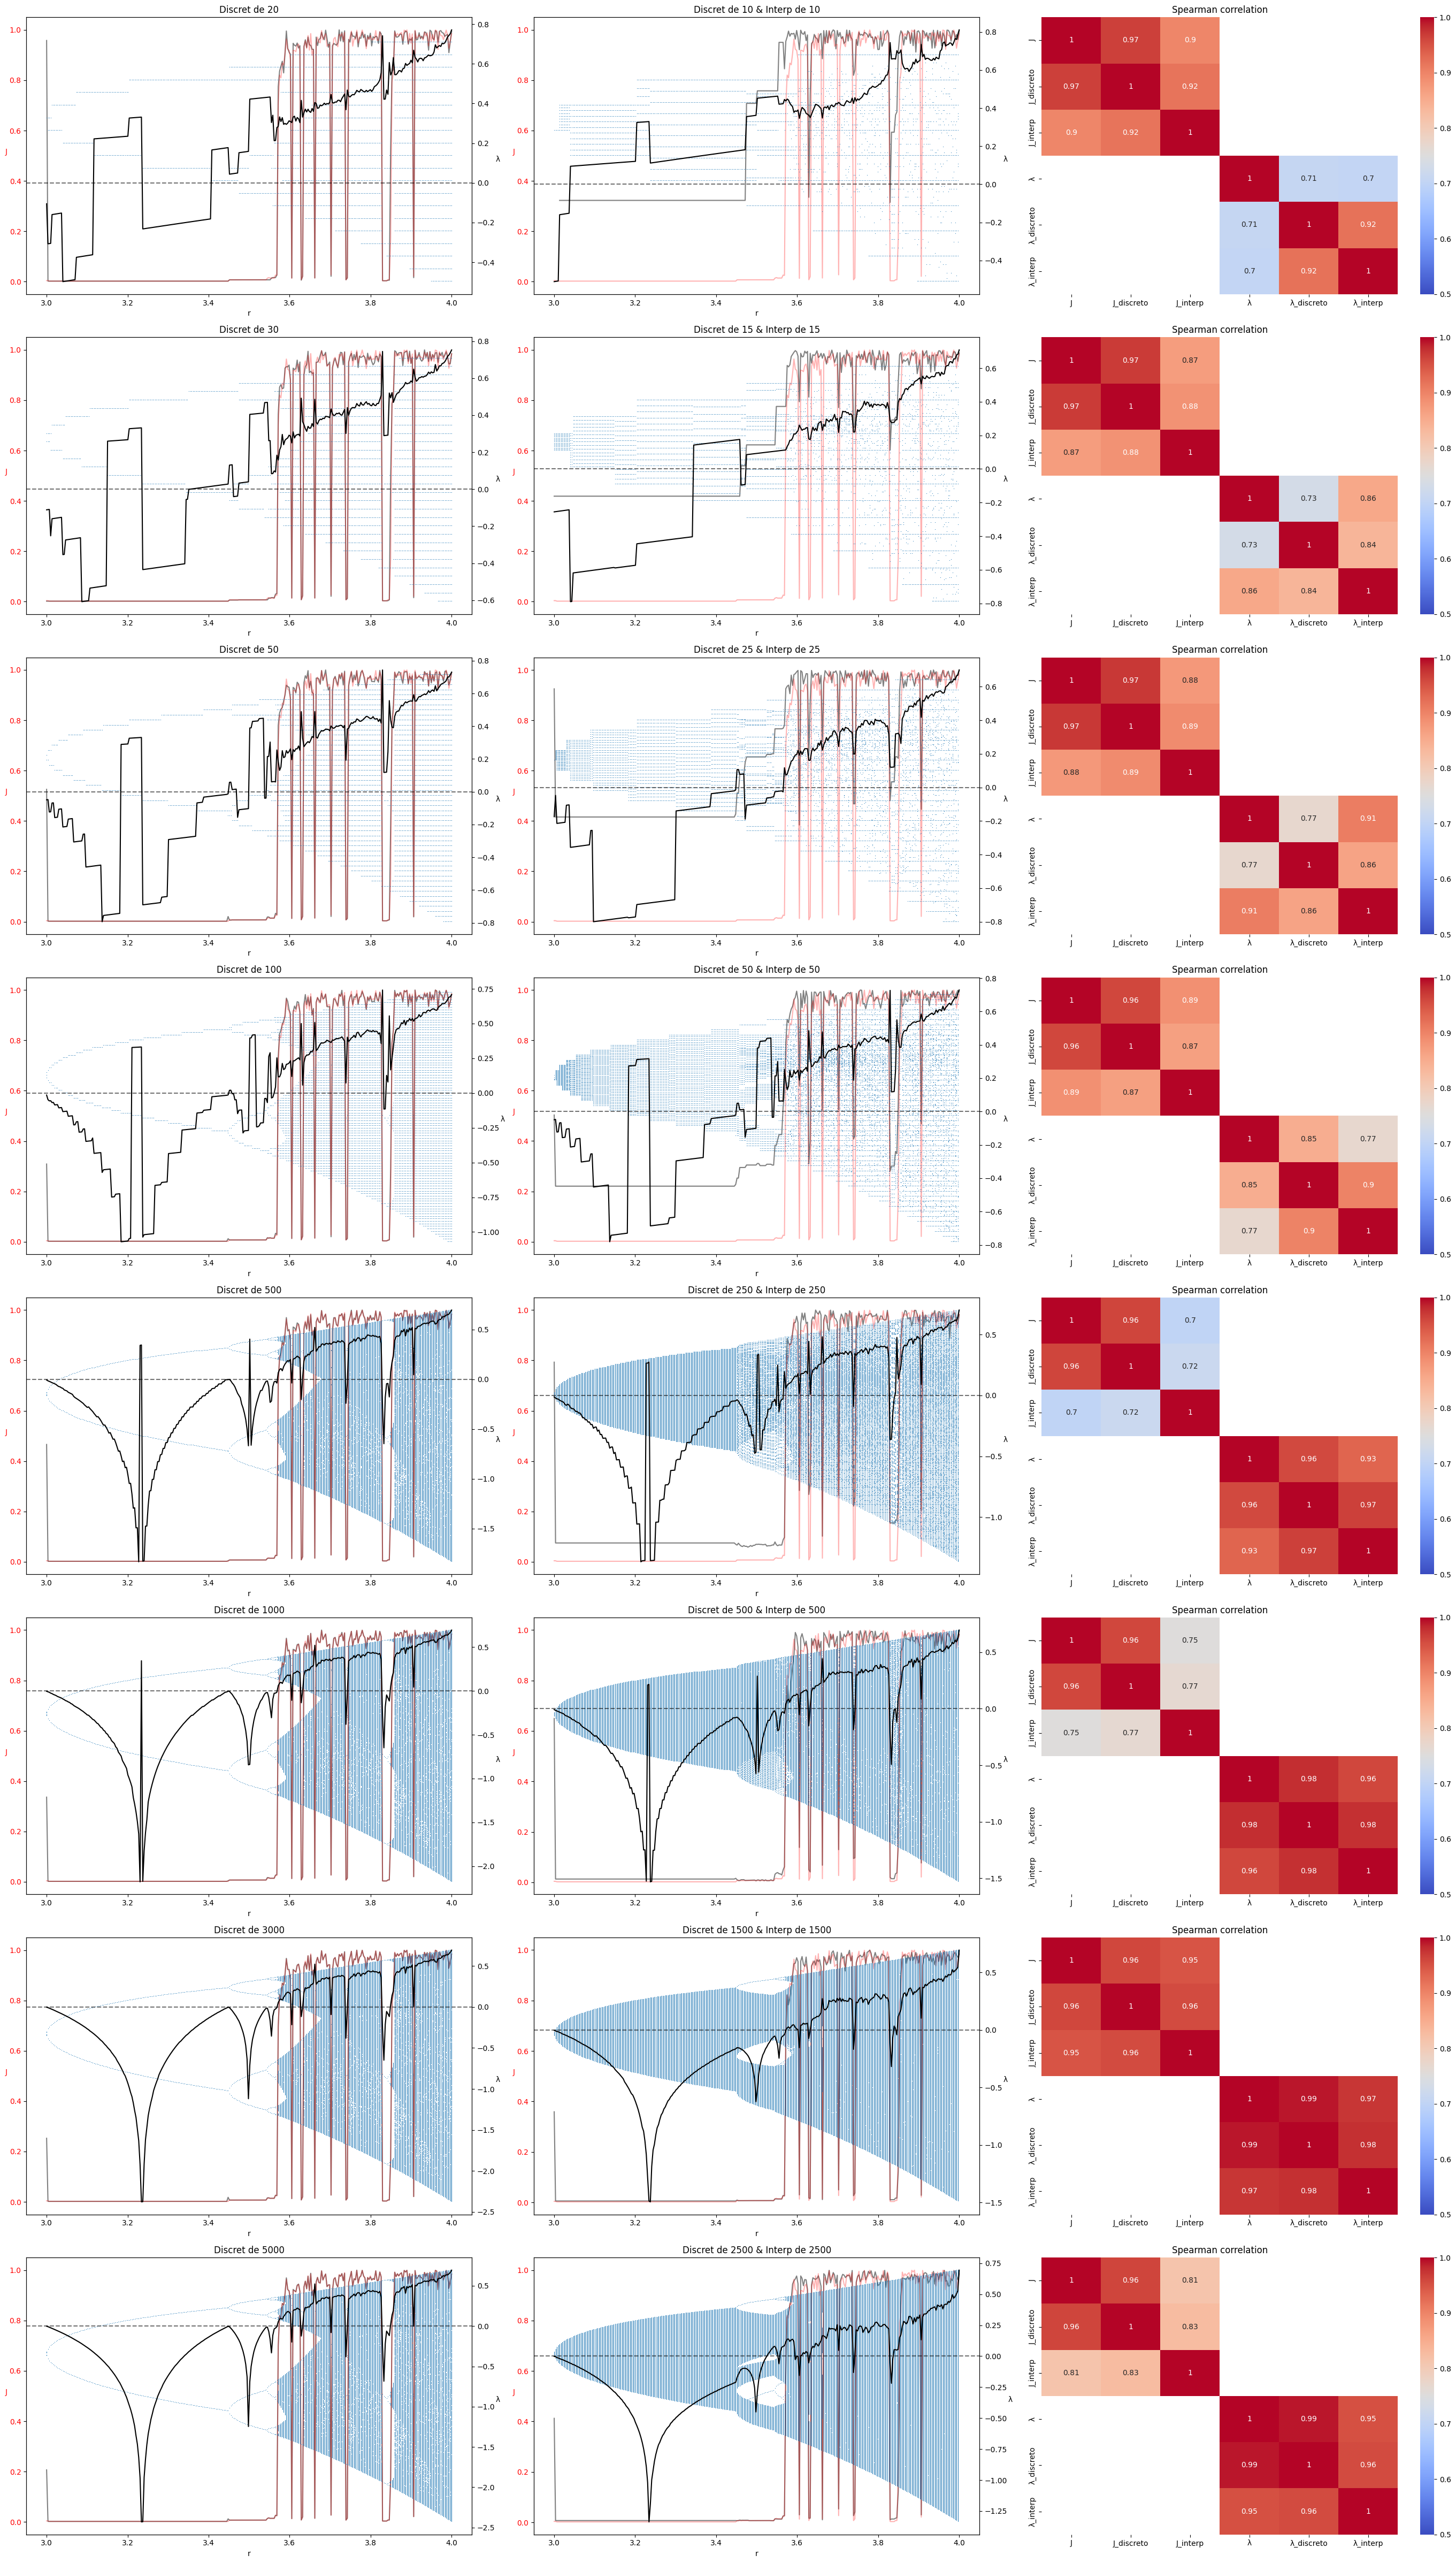

In [208]:
carpeta = 'logistic_map'
guardar = True

with open('logistic_map/lyapunov_continuo.txt', 'r') as f:
        lyapunov_continuo = [float(line.strip()) for line in f]

with open('logistic_map/j_logistic_continuo.txt', 'r') as f:
        J_continuo = [float(line.strip()) for line in f]

with open('logistic_map/j_index.txt', 'r') as f:
        J_index = [float(line.strip()) for line in f]

# Primera fila
splits = [20, 30, 50,100, 500, 1000, 3000, 5000]
fig, axs = plt.subplots(len(splits), 3, figsize=(28, 48))
for i,split in enumerate(splits):
    size = split//2

    # [0,0]
    if guardar == False:
        data = pd.read_csv(carpeta + '/df_' + str(split) + '.csv')
        data_discreto = pd.read_csv(carpeta + '/df_discreto_' + str(split) + '.csv')
        data_interp = pd.read_csv(carpeta + '/df_interp_' + str(split) + '.csv')
        J_values = data['J_discreto']
        r_values = data_discreto['r_values']
        orbit_values = data_discreto['orbit_values']
        lyapunov_values = data['λ_discreto']
        J_values_interp = data['J_interp']
        r_values_interp = data_interp['r_values_interp']
        orbit_values_interp = data_interp['orbit_values_interp']
        lyapunov_values_interp = data['λ_interp']
    
    if guardar == True:    
        J_index, J_values, r_values, orbit_values, lyapunov_values = plot_orbit_diagram(split,"si", 'no', size, False)

    axs[i, 0].plot(J_index, J_values, 'gray' , label='J', alpha = 1)
    axs[i, 0].plot(J_index, J_continuo, 'red', alpha = 0.3)
    axs[i, 0].plot(r_values, orbit_values, ',', label='Orbita', alpha=1)
    axs[i, 0].set_title(f'Discret de {split}')
    axs[i, 0].set_xlabel('r')
    axs[i, 0].set_ylabel('J', color='r', rotation = 360)
    axs[i, 0].tick_params(axis='y', labelcolor='r')

    ax2 = axs[i, 0].twinx()

    ax2.axhline(y=0, color='black', linestyle='--', alpha =0.55)
    ax2.plot(J_index, lyapunov_values, 'black', label = 'λ')
    ax2.set_ylabel('λ', color='black', rotation = 360)
    ax2.tick_params(axis='y', labelcolor='black')



    # [0, 1]
    if guardar == True:
        J_index, J_values_interp, r_values_interp, orbit_values_interp, lyapunov_values_interp = plot_orbit_diagram(split//2,"si", 'si', size, False)

    axs[i, 1].plot(J_index, J_values_interp, 'gray' , label='J', alpha = 1)
    axs[i, 1].plot(J_index, J_continuo, 'red', alpha = 0.3)
    axs[i, 1].plot(r_values_interp, orbit_values_interp, ',', label='Orbita', alpha=1)
    axs[i, 1].set_xlabel('r')
    axs[i, 1].set_ylabel('J', color='r', rotation = 360)
    axs[i, 1].tick_params(axis='y', labelcolor='r')
    axs[i, 1].set_title(f'Discret de {split//2} & Interp de {size}')

    ax3 = axs[i, 1].twinx()

    ax3.axhline(y=0, color='black', linestyle='--', alpha =0.55)
    ax3.plot(J_index, lyapunov_values_interp, 'black', label = 'λ')
    ax3.set_ylabel('λ', color='black', rotation = 360)
    ax3.tick_params(axis='y', labelcolor='black')

    # [0, 2]
    """Compute"""
    ########################
    if guardar == True:
        data = pd.DataFrame({
                'J': J_continuo,
                'J_discreto': J_values,
                'J_interp': J_values_interp,
                'λ': lyapunov_continuo,
                'λ_discreto': lyapunov_values,
                'λ_interp': lyapunov_values_interp,
        })
        # data.to_csv(carpeta + '/df_' + str(split) + '.csv', index=False)

        data_interp = pd.DataFrame({
                'r_values_interp': r_values_interp,
                'orbit_values_interp': orbit_values_interp,
        })

        data_discreto = pd.DataFrame({
                'r_values': r_values,
                'orbit_values': orbit_values,
        })

        # with open('J_index.txt', "w") as f:
        #         for item in J_index: # a menos que cambie tamaño de iteraciones de función, no guardar J_index
        #         f.write(f"{item}\n")
        
        # data_discreto.to_csv(carpeta + '/df_discreto_' + str(split) + '.csv', index=False)
        # data_interp.to_csv(carpeta + '/df_interp_' + str(split) + '.csv', index=False)
    ########################

    corr_spearman = data.corr(method='spearman')
    mask = np.ones_like(corr_spearman, dtype=bool)
    for k in [0, 1, 2]:
        for l in [0, 1, 2]:
            mask[k,l] = False
        for l in [3, 4, 5]:
            mask[k+3, l] = False 
    corr_spearman = corr_spearman.where(~mask)
    sns.heatmap(corr_spearman, ax=axs[i, 2], annot=True, cmap='coolwarm', mask = mask, vmin=0.5, vmax=1.0)
    axs[i, 2].set_title('Spearman correlation')

# Ajustar el layout para que no haya superposición de títulos y etiquetas
plt.tight_layout()

# Mostrar el plot
plt.show()


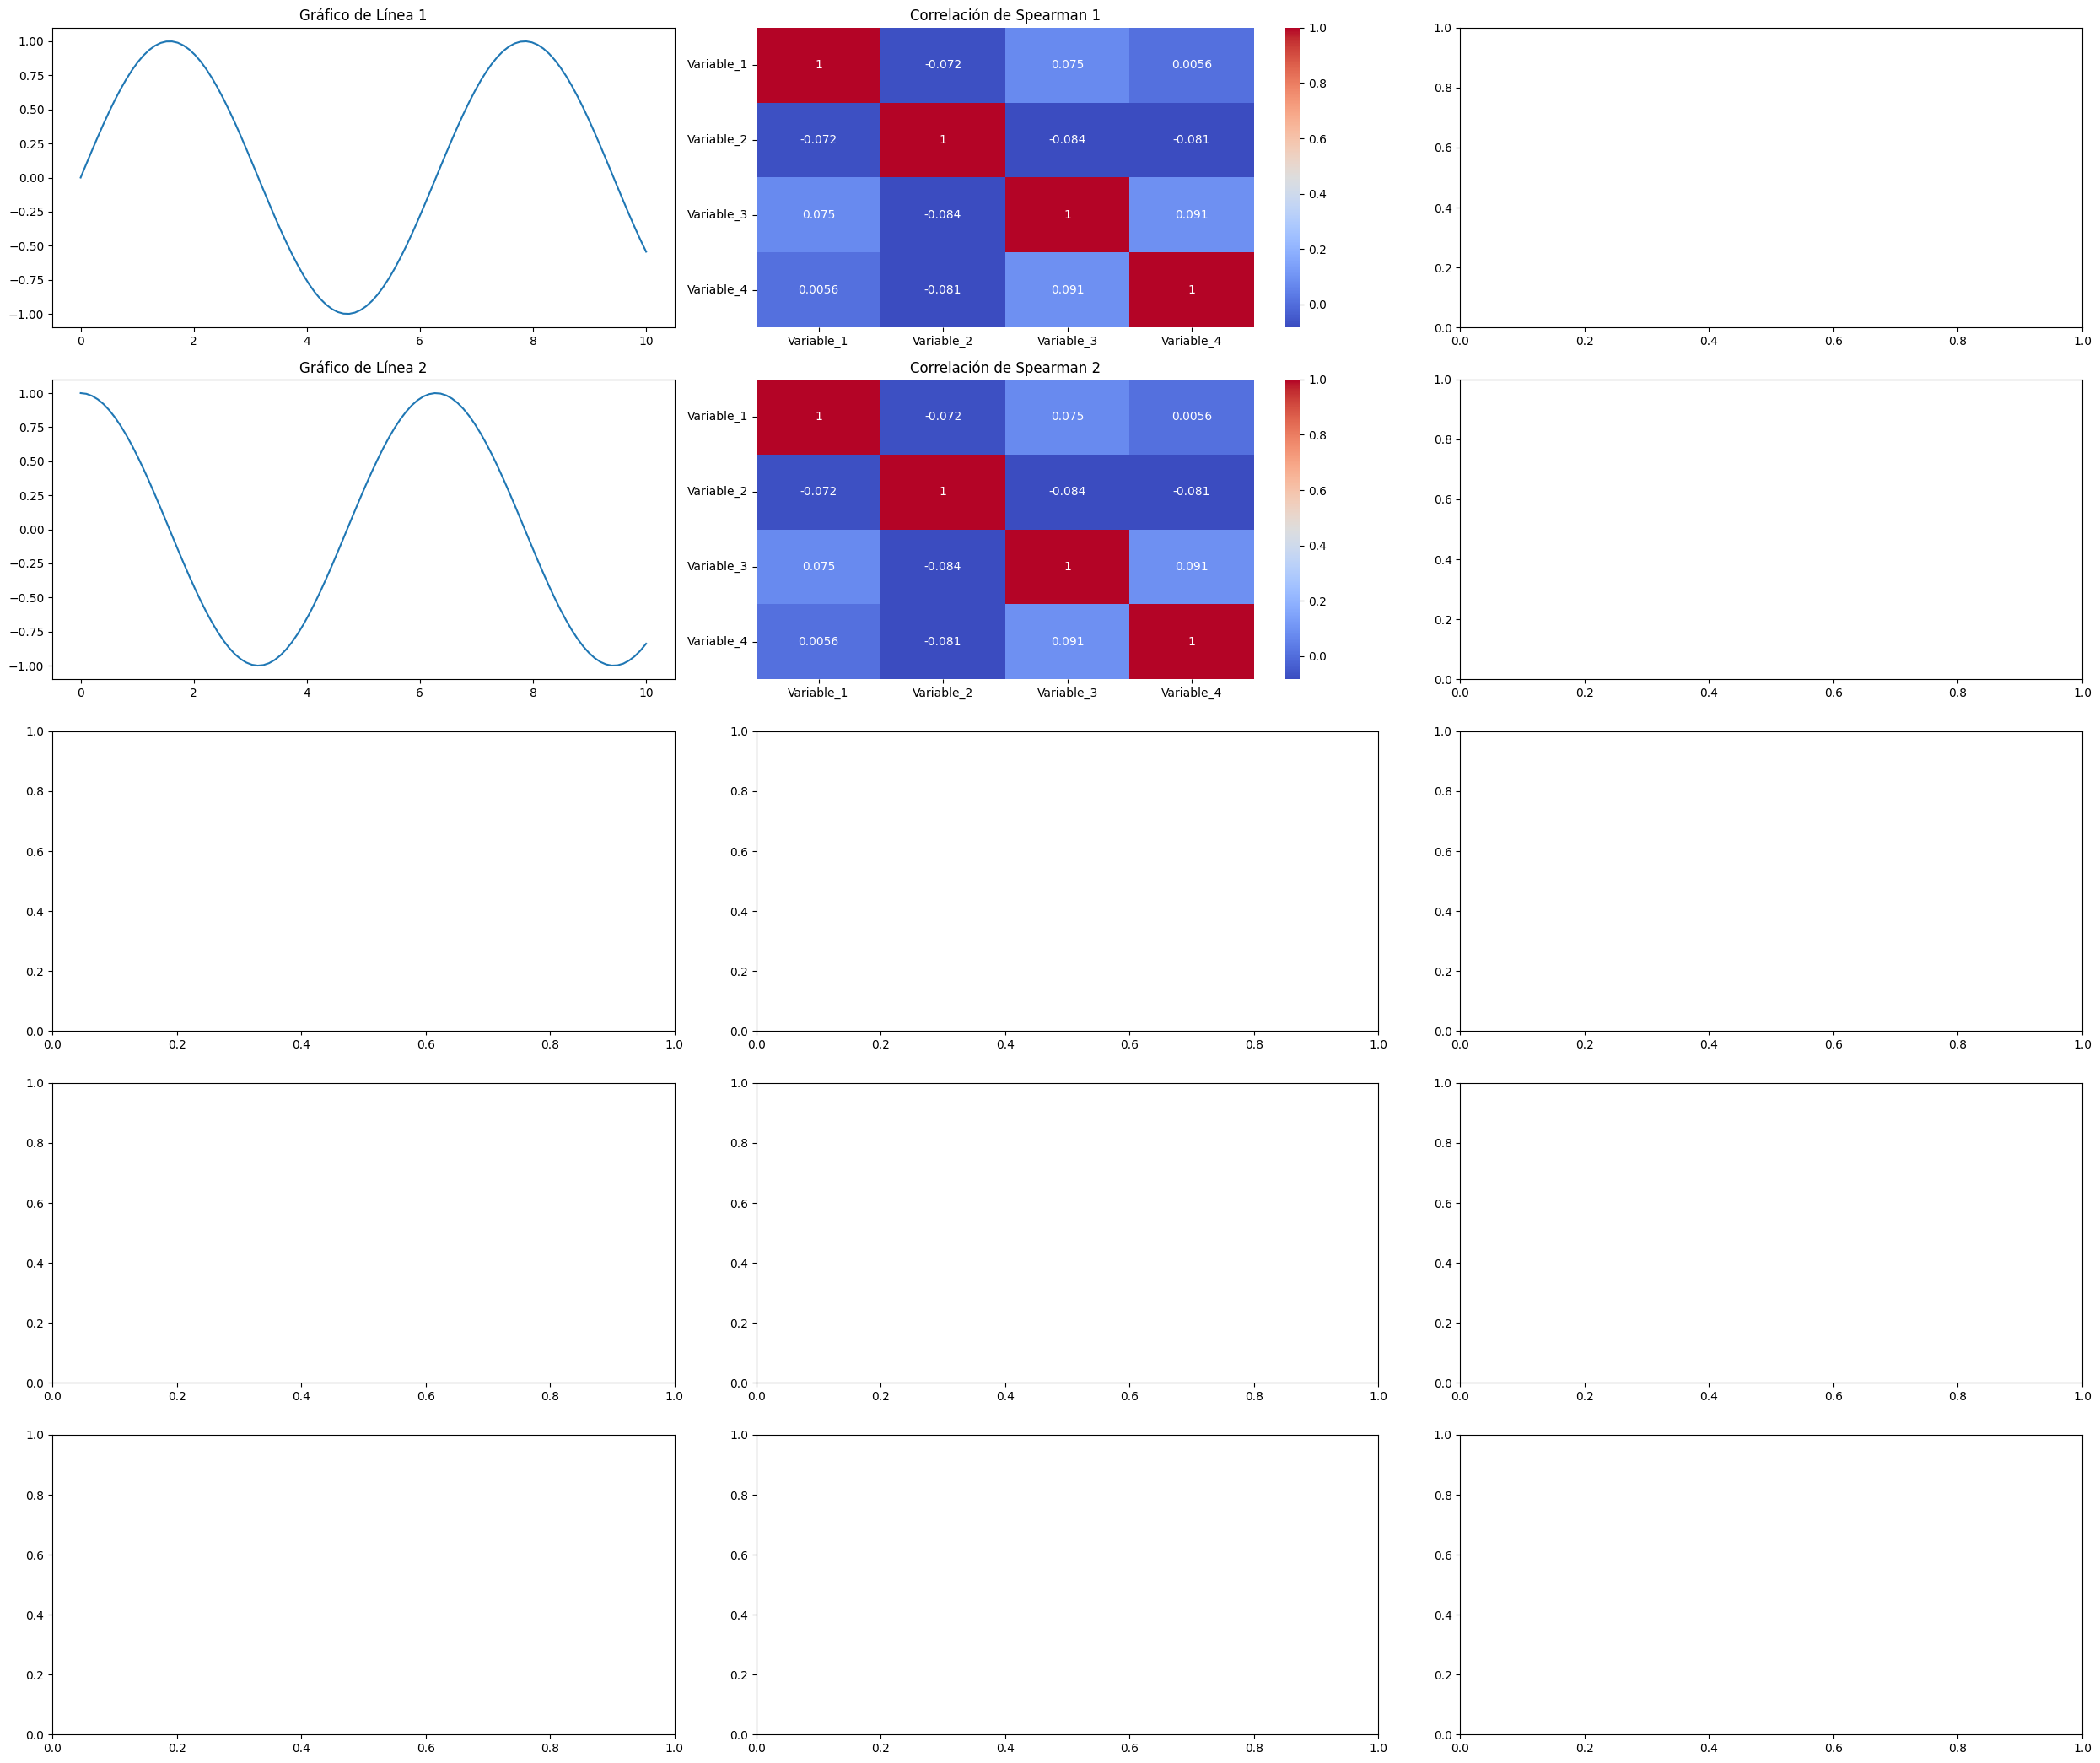

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Datos de ejemplo para los gráficos de línea
x = np.linspace(0, 10, 100)
y1 = np.sin(x)
y2 = np.cos(x)

# Datos de ejemplo para las matrices de correlación
data = pd.DataFrame({
    'Variable_1': np.random.rand(100),
    'Variable_2': np.random.rand(100),
    'Variable_3': np.random.rand(100),
    'Variable_4': np.random.rand(100)
})

# Crear la figura con subplots 2x2
fig, axs = plt.subplots(5, 3, figsize=(25, 21))

# Gráfico de línea en la primera fila, primera columna
axs[0, 0].plot(x, y1)
axs[0, 0].set_title('Gráfico de Línea 1')

# Gráfico de línea en la segunda fila, primera columna
axs[1, 0].plot(x, y2)
axs[1, 0].set_title('Gráfico de Línea 2')

# Matriz de correlación de Spearman en la primera fila, segunda columna
corr_spearman_1 = data.corr(method='spearman')
sns.heatmap(corr_spearman_1, ax=axs[0, 1], annot=True, cmap='coolwarm')
axs[0, 1].set_title('Correlación de Spearman 1')

# Matriz de correlación de Spearman en la segunda fila, segunda columna
corr_spearman_2 = data.corr(method='spearman')
sns.heatmap(corr_spearman_2, ax=axs[1, 1], annot=True, cmap='coolwarm')
axs[1, 1].set_title('Correlación de Spearman 2')

# Ajustar el layout para que no haya superposición de títulos y etiquetas
plt.tight_layout()

# Mostrar el plot
plt.show()
